In [2]:
from google.colab import files
uploaded0 = files.upload()

Saving 0_28_28.png to 0_28_28.png


In [3]:
from google.colab import files
uploaded0= files.upload()

Saving x_28_28.png to x_28_28.png


In [0]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)

I want to test various Neural Network architectures. But I want to test it for my samples. It is hard to find a set as I want. I want to begin with simple shapes. I will be generating data with single image and expand this idea.

In [0]:
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K

def img_as_np(img_name):
  image_orig = cv2.imread('/content/'+img_name,0)
  gray = cv2.resize(image_orig, (28, 28))
  return gray

def show_img(img_name):
  img = cv2.imread('/content/'+img_name,0)
  imgplot = plt.imshow(img,cmap='gray')
  plt.show()
  

In [0]:
import numpy as np
x_raw = np.array([img_as_np("0_28_28.png"),img_as_np("x_28_28.png")])
y_raw = np.array([0,1])

# input image dimensions
img_rows, img_cols = 28, 28

In [0]:
if K.image_data_format() == 'channels_first':
    x_raw = x_raw.reshape(x_raw.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_raw = x_raw.reshape(x_raw.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

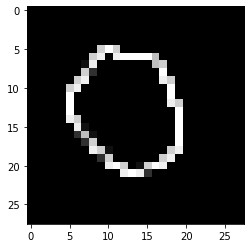

In [29]:
show_img("0_28_28.png")

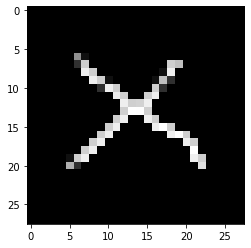

In [30]:
show_img("x_28_28.png")

Generate data by shifting and rotating. Here I am generating some bad data, shapes go out of window. But I liked the dataset and wanted to test like this.

In [0]:
import math
  
def generate_data(sample_size,x_orig,y_orig,rotation_high,rotation_low,shift_high,shift_low):
  
  if K.image_data_format() == 'channels_first':
    x_orig = x_orig.reshape(x_orig.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
  else:
    x_orig = x_orig.reshape(x_orig.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
  
  
  
  rotation_size = int(math.sqrt(sample_size))
  shift_size = sample_size // rotation_size

  rotations = np.random.random_sample(sample_size) *(rotation_high-rotation_low) + rotation_low
   
  
  shifts = np.random.random_sample(sample_size) *(shift_high-shift_low) + shift_low

  #print("rotations",rotations)
  #print("shifts",shifts)
  count = 1
  generated_data = []
  generated_labels = []
  for rotation in rotations:
    for shift in shifts:
      datagen = ImageDataGenerator(rotation_range=rotation,width_shift_range=shift, height_shift_range=shift)
      # fit parameters from data
      datagen.fit(x_orig)
      # configure batch size and retrieve one batch of images
      for X_batch, y_batch in datagen.flow(x_orig, y_orig, batch_size=2):
        for i in range(0, 2):          
          #show_images(X_batch)
          count += 1
          generated_data.append(X_batch[i])
          generated_labels.append(y_batch[i])
        if count >= sample_size:
          return [generated_data,generated_labels]

In [0]:
def generate_train_test_data(train_size,test_size,train_params,test_params):
  x1,y1 = generate_data(train_size,x_raw.copy(),y_raw.copy(),train_params[0],train_params[1],train_params[2],train_params[3])
  x2,y2 = generate_data(test_size,x_raw.copy(),y_raw.copy(),test_params[0],test_params[1],test_params[2],test_params[3])
  x_train2 = np.array(x1)
  y_train2 = np.array(y1)

  x_validate2 = np.array(x2)
  y_validate2 = np.array(y2)
  return (x_train2,y_train2,x_validate2,y_validate2)

Sample code from Keras , i just played a little.

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K

def run_model(x_train,y_train,x_validate,y_validate,epochs=50,batch_size = 50,optimizer=keras.optimizers.Adagrad()):
  
  
  
  num_classes = 2
  
  
  # input image dimensions
  img_rows, img_cols = 28, 28
  input_shape = x_train[0].shape
  
  
  
  x_train = x_train.astype('float32')
  x_validate = x_validate.astype('float32')
  x_train /= 255
  x_validate /= 255
  
  
  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_validate = keras.utils.to_categorical(y_validate, num_classes)
  
  
  
  
  
  # Build the model
  model = Sequential()
  model.add(Conv2D(32, kernel_size = (5, 5),
                   activation = 'relu',
                   input_shape = input_shape))
  model.add(Conv2D(32, kernel_size = (3, 3),
                   activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(64, (3, 3), activation = 'relu'))
  model.add(Conv2D(64, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Flatten())
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(num_classes, activation = 'softmax'))
  
  model.compile(loss = keras.losses.categorical_crossentropy,
                optimizer = optimizer,
                metrics = ['accuracy'])
  
  
  history = model.fit(x_train,y_train,
                      batch_size=batch_size,
                      epochs = epochs,                    
                      verbose = 0,
                      validation_data = (x_validate, y_validate)
                      )
  
  
  
  
  
  score = model.evaluate(x_validate, y_validate, verbose=0)
  return [history, score]

Utility methods for showing images and plotting performance.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def show_images(img_batch):
  w=10
  h=10
  fig=plt.figure(figsize=(14, 6))
  columns = 6
  rows = len(img_batch) // columns
  
  for i in range(1, columns*rows +1):
    if i < len(img_batch)+1:
      img = img_batch[i -1 ].reshape(28,28)
      fig.add_subplot(rows, columns, i)
      plt.imshow(img,cmap='gray')
  plt.show()

def plot_history(history,current_plot,title):
  current_plot.plot(history.history['acc'] ,label =  " acc " )
  current_plot.plot(history.history['val_acc'] ,label =  " val acc ")
  current_plot.set_title( title)
  current_plot.legend()

def plot_performance(all_scores):
  fig, ax = plt.subplots(figsize=(20,10),nrows=3, ncols=len(all_scores)//3)
  fig.tight_layout()

  next = 0
  for row in ax:
    for col in row:      
      plot_history(all_scores[next][1][0], col,all_scores[next][0])
      next += 1

def run(x_train,y_train,x_validate,y_validate,epochs=50,batch_size = 50):
  scores = []
  for test in optimizers :
    history = run_model(x_train,y_train,x_validate,y_validate,epochs=epochs,batch_size = 50,optimizer=test.optimizer)
    scores.append((test.display(),history))
  plot_performance(scores)  

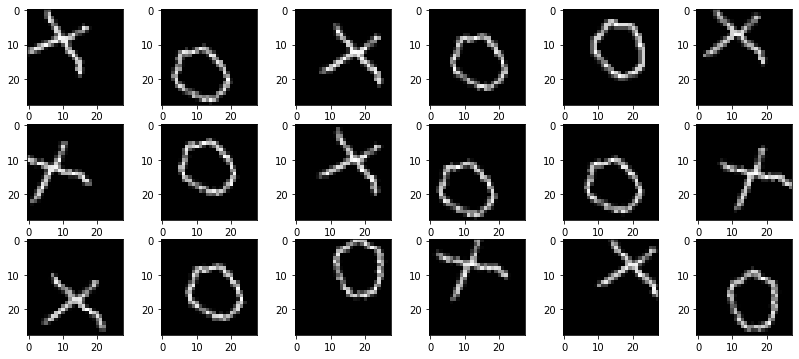

In [39]:
#Generate a batch of 500 images and show samples from both test and train data
x_train_500,y_train_500,x_validate_500,y_validate_500 = generate_train_test_data(500,20,[10,30,0.2,0.4],[15,35,0.3,0.5])
show_images(x_train_500[0:20,:,:,:])
  

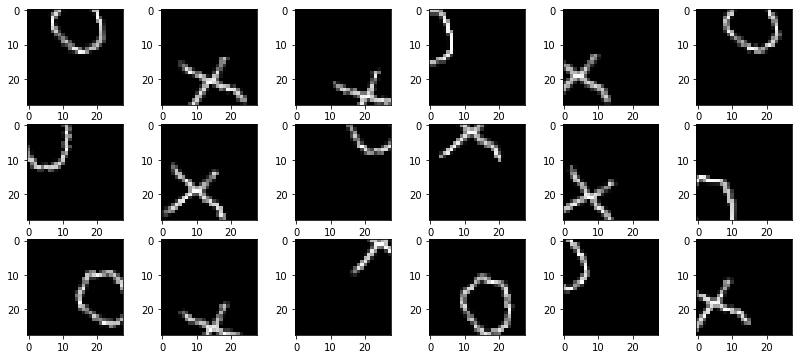

In [40]:
show_images(x_validate_500[0:20,:,:,:])

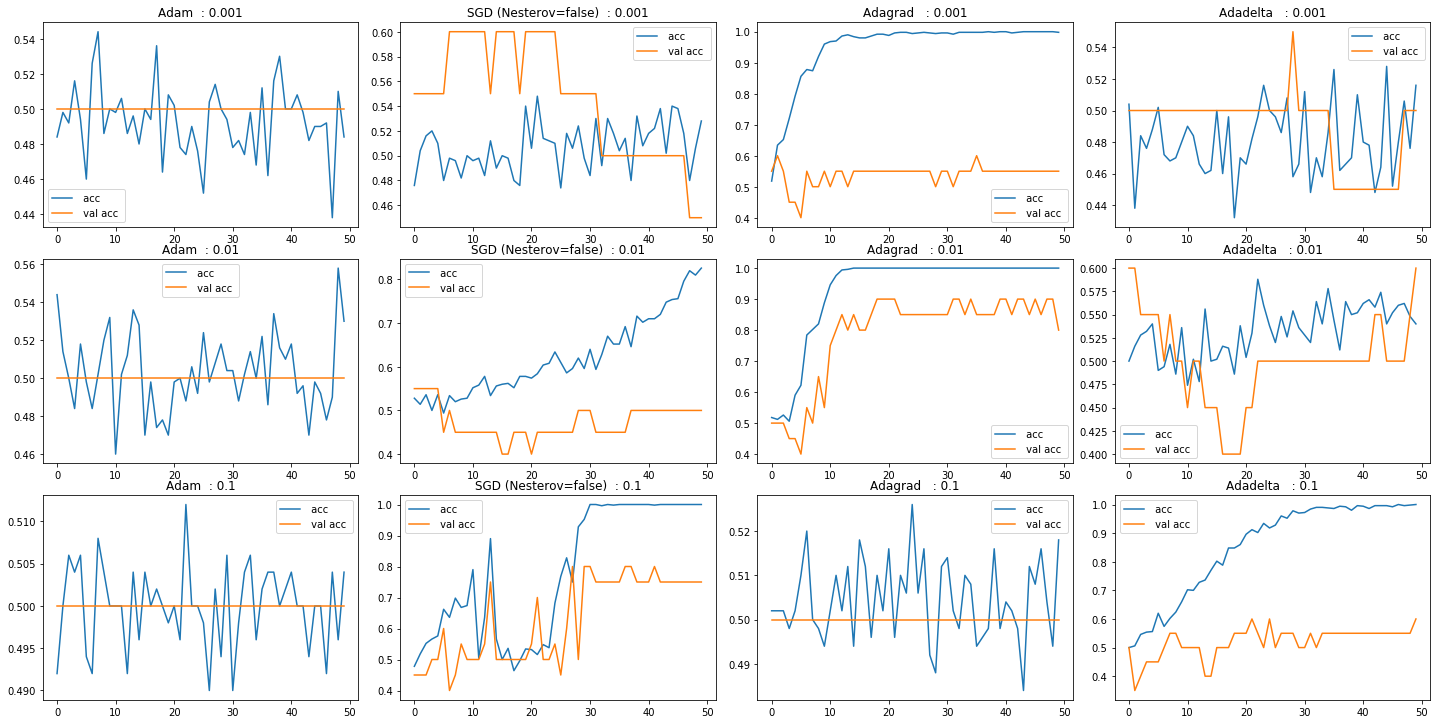

In [41]:
run(x_train_500,y_train_500,x_validate_500,y_validate_500 )

We can think data set as very noisy. Adagrad 0.01 seems best performing config.

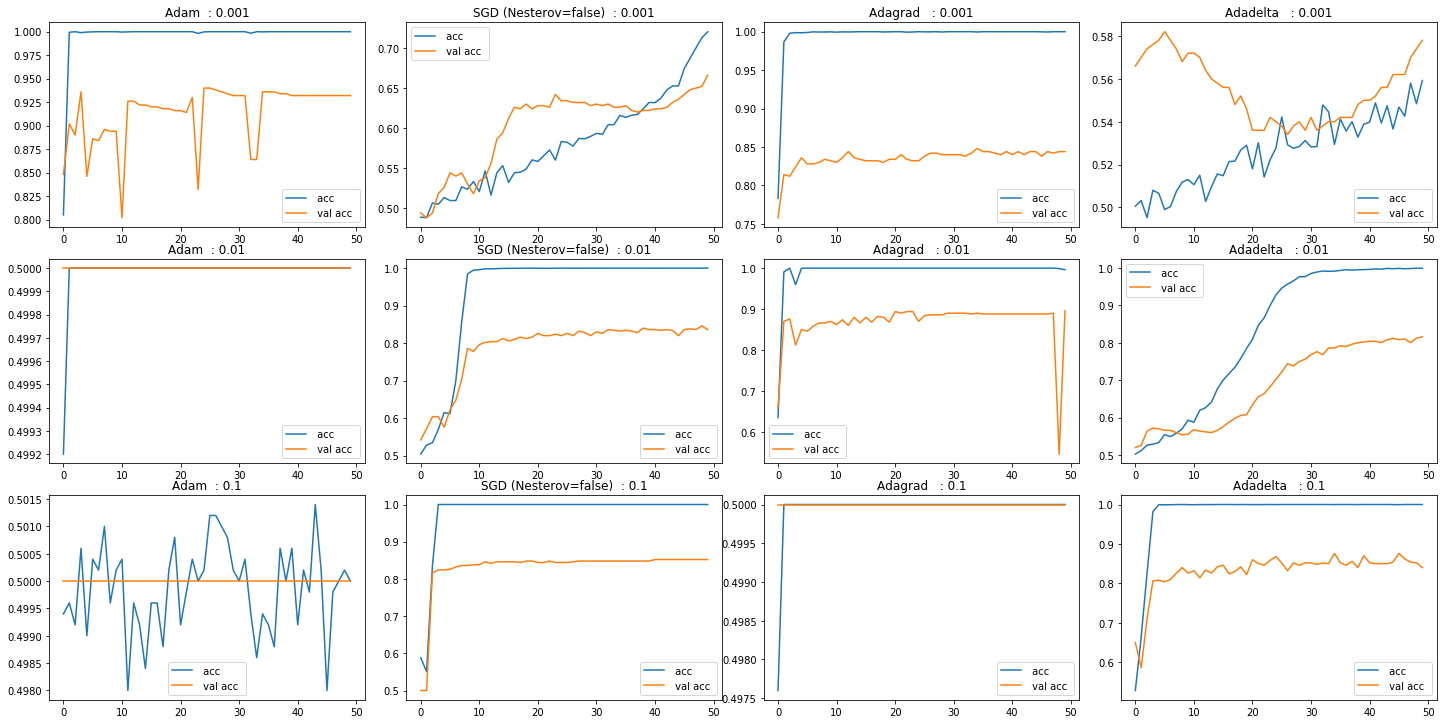

In [42]:
x_train_5000,y_train_5000,x_validate_5000,y_validate_5000 = generate_train_test_data(5000,500,[10,30,0.2,0.4],[15,35,0.3,0.5])
run(x_train_5000,y_train_5000,x_validate_5000,y_validate_5000,epochs=50,batch_size = 500) 

When we increase the set to 5K samples,more algorithms begin to perform well.